In [1]:
# GPU‑Only XGBoost for Predictive Maintenance


In [2]:
# Cell 1: Imports & warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.metrics     import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import xgboost as xgb
from xgboost import XGBClassifier


In [5]:
# Cell 2: Load data & prepare DMatrix
dtype = {'norm_power':'float32','norm_temp_diff':'float32','norm_tool_wear_adjusted':'float32','Bool_MF':'bool'}
cols  = ['norm_power','norm_temp_diff','norm_tool_wear_adjusted','Bool_MF']

df = pd.read_csv("full_normalized.csv", dtype=dtype, usecols=cols)
X = df[['norm_power','norm_temp_diff','norm_tool_wear_adjusted']]
y = df['Bool_MF'].astype('int8')
del df; gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

from xgboost import DeviceQuantileDMatrix

# use a GPU‐resident DMatrix
dtrain = DeviceQuantileDMatrix(X_train, label=y_train, feature_names=X.columns.tolist())
dtest  = DeviceQuantileDMatrix(X_test,  label=y_test,  feature_names=X.columns.tolist())



In [6]:
# Cell 3: GPU Hyperparameter tuning via RandomizedSearchCV
param_dist = {
    'n_estimators': [100,150,200,250,300],
    'max_depth':    [4,6,8,10],
    'learning_rate':[0.01,0.05,0.1,0.15],
    'subsample':    [0.7,0.8,0.9,1.0],
    'colsample_bytree':[0.7,0.8,0.9,1.0],
    'gamma':        [0,0.1,0.5,1],
    'reg_alpha':    [0,0.01,0.1,1],
    'reg_lambda':   [1,1.5,2,3]
}

xgb_clf = XGBClassifier(objective='binary:logistic',
                        eval_metric='logloss',
                        tree_method='hist', device='cuda',
                        random_state=42)

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
rs = RandomizedSearchCV(xgb_clf, param_dist, n_iter=30,
                        scoring='accuracy', cv=rkf,
                        n_jobs=1, verbose=1, random_state=42)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("CV accuracy:", rs.best_score_)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.9}
CV accuracy: 0.9631550697192276


In [7]:
# Cell 4: Refit best Booster on GPU
gpu_params = {
    'objective':    'binary:logistic',
    'eval_metric':  'logloss',
    'tree_method':  'gpu_hist',       # GPU‐only histogram
    'predictor':    'gpu_predictor',  # GPU predictor for inference
    'gpu_id':       0,
    **rs.best_params_                # your tuned hyperparameters
}

booster = xgb.train(
    gpu_params,
    dtrain,
    num_boost_round=rs.best_params_['n_estimators'],
    evals=[(dtest, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)
print("Stopped at round:", booster.best_iteration + 1)


# Train/test probabilities & preds at default 0.5
proba_train = booster.predict(dtrain, iteration_range=(0,booster.best_iteration+1))
proba_test  = booster.predict(dtest,  iteration_range=(0,booster.best_iteration+1))
pred_train50 = (proba_train >= .5).astype(int)
pred_test50  = (proba_test  >= .5).astype(int)

acc_tr50 = accuracy_score(y_train, pred_train50)
acc_te50 = accuracy_score(y_test,  pred_test50)
print(f"Accuracy @0.5 → train {acc_tr50:.4f}, test {acc_te50:.4f}")


C:\Users\pdsch\.conda\envs\Jupyter_ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:46] WARNING: D:\bld\xgboost-split_1742444215012\work\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
C:\Users\pdsch\.conda\envs\Jupyter_ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:46] WARNING: D:\bld\xgboost-split_1742444215012\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\pdsch\.conda\envs\Jupyter_ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:46] WARNING: D:\bld\xgboost-split_1742444215012\work\src\learner.cc:740: 
Parameters: { "n_estimators", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Stopped at round: 185
Accuracy @0.5 → train 0.9850, test 0.9482


C:\Users\pdsch\.conda\envs\Jupyter_ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:47] WARNING: D:\bld\xgboost-split_1742444215012\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



--- Threshold = 0.5 ---
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1931
           1       0.96      0.93      0.95      1930

    accuracy                           0.95      3861
   macro avg       0.95      0.95      0.95      3861
weighted avg       0.95      0.95      0.95      3861



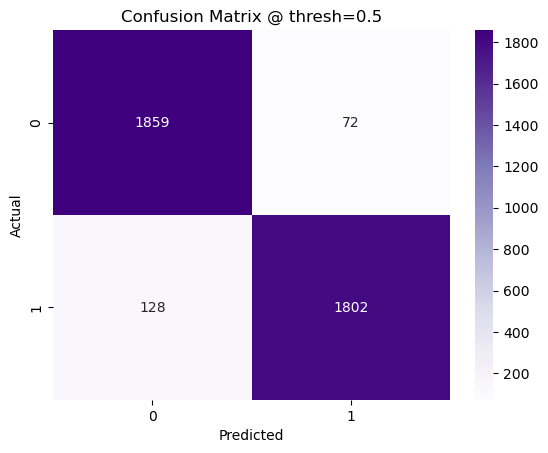


--- Threshold = 0.2 ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1931
           1       0.92      0.97      0.94      1930

    accuracy                           0.94      3861
   macro avg       0.94      0.94      0.94      3861
weighted avg       0.94      0.94      0.94      3861



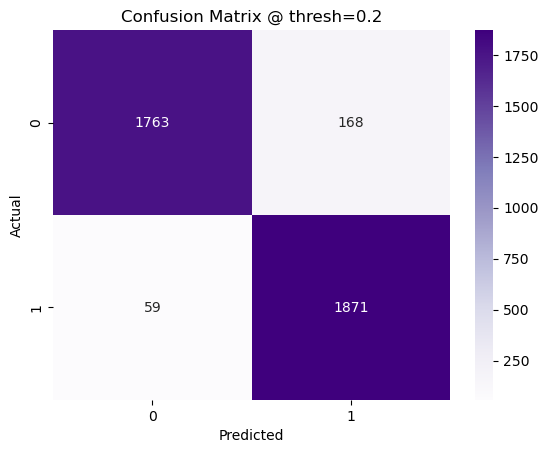

In [8]:
# Cell 5: Confusion matrices & reports at 0.5 and 0.2
for thresh in [0.5, 0.2]:
    pred_test = (proba_test >= thresh).astype(int)
    print(f"\n--- Threshold = {thresh} ---")
    print(classification_report(y_test, pred_test))
    cm = confusion_matrix(y_test, pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
    plt.title(f"Confusion Matrix @ thresh={thresh}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()


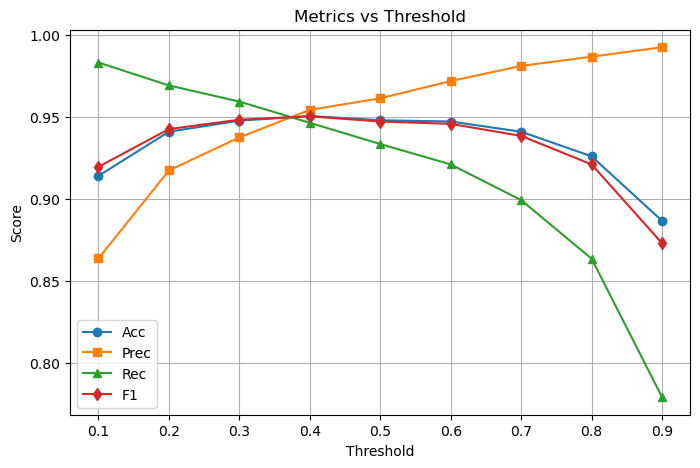

In [9]:
# Cell 6: Metrics vs threshold (accuracy, precision, recall, F1)
ths = np.linspace(0.1,0.9,9)
accs, precs, recs, f1s = [],[],[],[]
for t in ths:
    p = (proba_test >= t).astype(int)
    accs.append(accuracy_score(y_test,p))
    precs.append(precision_score(y_test,p))
    recs.append(recall_score(y_test,p))
    f1s.append(f1_score(y_test,p))

plt.figure(figsize=(8,5))
plt.plot(ths, accs, marker='o', label='Acc')
plt.plot(ths, precs,marker='s', label='Prec')
plt.plot(ths, recs,marker='^', label='Rec')
plt.plot(ths, f1s, marker='d', label='F1')
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Metrics vs Threshold"); plt.legend(); plt.grid(True)
plt.show()


Train  @0.5: 0.9850
Test   @0.5: 0.9482
Diff         0.0368


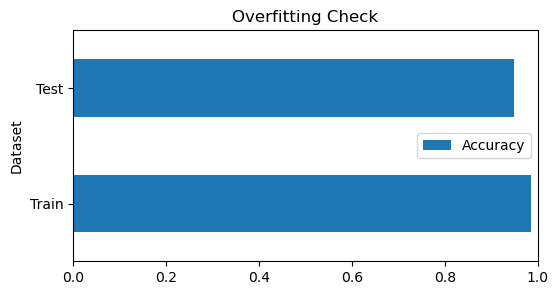

In [10]:
# Cell 7: Overfitting check (train vs test accuracy)
acc_tr = accuracy_score(y_train, (proba_train>=.5).astype(int))
acc_te = accuracy_score(y_test,  (proba_test >=.5).astype(int))
diff   = acc_tr - acc_te
print(f"Train  @0.5: {acc_tr:.4f}")
print(f"Test   @0.5: {acc_te:.4f}")
print(f"Diff         {diff:.4f}")

# bar plot
pd.DataFrame({
    'Dataset':['Train','Test'],
    'Accuracy':[acc_tr,acc_te]
}).set_index('Dataset').plot.barh(figsize=(6,3))
plt.title("Overfitting Check"); plt.xlim(0,1); plt.show()


In [11]:
# Cell 8: Save booster + threshold
booster.save_model("xgb_gpu_model.bin")
import joblib
joblib.dump(0.20, "xgb_threshold_0.20.joblib")
print("Model → xgb_gpu_model.bin\nThreshold → xgb_threshold_0.20.joblib")


Model → xgb_gpu_model.bin
Threshold → xgb_threshold_0.20.joblib


C:\Users\pdsch\.conda\envs\Jupyter_ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:48] WARNING: D:\bld\xgboost-split_1742444215012\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
